# Some tips with xarray and pandas

- We have massively different levels here
- Try to make some aims for technical skills you can learn!
- If you are beginning with python --> learn the basics
- If you are good at basic python --> learn new packages
- If you know all the packages --> improve your skills with producing your own software etc. 
- If you don't know git and github --> get better at this!


<span style="color:red;font-weight:700;font-size:20px">
Please feel free to come with suggestions and extra input as we go! 
</span>



<span style="color:blue;font-weight:700;font-size:20px">
Questions:

- How many have used jupyter lab?     
- How many have used pandas? 
- How many have used xarray? 
</span>



## What are pandas and xarray?
- Pandas --> like a spreadsheet 2D data with columns and rows
- xarray --> like pandas, but in N dimensions
- **Use the functionality these packages gives you! Will help you avoid mistakes. Try to get as good as possible :)**


### Pandas
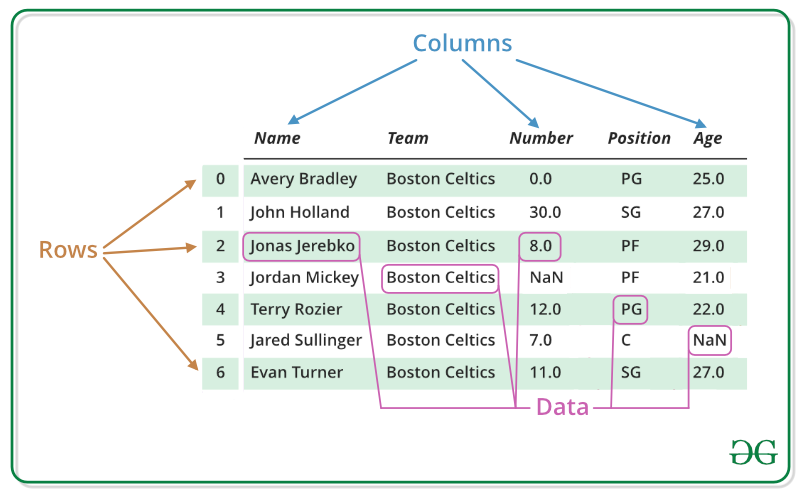
(Source: https://www.geeksforgeeks.org/python-pandas-dataframe/)

### Xarray
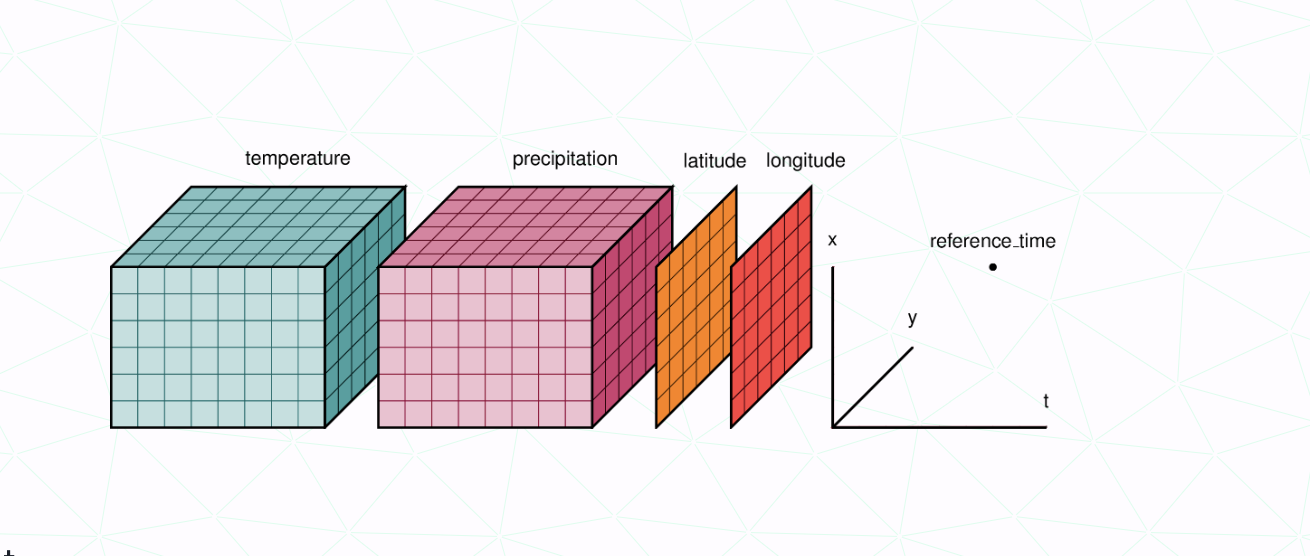
(Source: https://docs.xarray.dev/)

# 1. Read in CMIP6 data: We will skip this next part, but you can check it later to read data: 
#### Import python packages

In [ ]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

### Open CMIP6 online catalog

In [ ]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col


### Search corresponding data 

Please check [here](https://pangeo-data.github.io/escience-2022/pangeo101/data_discovery.html?highlight=cmip6) for info about CMIP and variables :) 

Particularly useful is maybe the variable search which you find here: https://clipc-services.ceda.ac.uk/dreq/mipVars.html 

In [81]:
cat = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon','fx','AERmon'], 
                 variable_id=['tas','hurs', 'areacella','mmrso4' ], member_id=['r1i1p1f1'])
cat.df


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r1i1p1f1,fx,areacella,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
1,CMIP,NCAR,CESM2,historical,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
2,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308
3,CMIP,NCAR,CESM2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190308


### Create dictionary from the list of datasets we found
- This step may take several minutes so be patient!

In [ ]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})

In [ ]:
list(dset_dict.keys())

### Open dataset

- Use `xarray` python package to analyze netCDF dataset
- `open_dataset` allows to get all the metadata without loading data into memory. 
- with `xarray`, we only load into memory what is needed.

In [ ]:
ds1 = dset_dict['CMIP.NCAR.CESM2.historical.Amon.gn']
ds2 = dset_dict['CMIP.NCAR.CESM2.historical.fx.gn']
ds3 = dset_dict['CMIP.NCAR.CESM2.historical.AERmon.gn']

In [ ]:
ds1

In [ ]:
ds3

<span style="color:black;font-weight:700;font-size:20px">
Since I have already checked that these datasets are on the same grid, we can merge them:
</span>




In [ ]:
ds_list = [dset_dict[l].drop('lat_bnds') for l in dset_dict.keys()]
ds = xr.merge(ds_list)

## 1.1 Reading in the data from file:

```python
path='filename.nc'
ds = xr.open_dataset(path)
```

##### Opening multiple files:

```python

list_of_files = [
    'file1.nc',
    'file2.nc'
]
xr.open_mfdataset(list_of_files, concat_dim='time',combine='by_coords')
```

# 2. Check how your dataset looks

#### Different types of information/data:
- Coordinates
- Data variables
- Global attributes
- Variable attributes

In [ ]:
ds

# 3. Sometimes we want to do some nice tweaks before we start: 

### Selecting data and super quick plotting:

xarray loads data only when it needs to (it's lazy, Anne can explain), and you might want to early on define the subset of data you want to look at so that you don't end up loading a lot of extra data. 


##### See [here](http://xarray.pydata.org/en/stable/user-guide/indexing.html) for nice overview

In order to reduce unecessary calculations and loading of data, think about which part of the data you want, and slice early on. 

### Slice in time: the sel method

In [ ]:
dss = ds.sel(time = slice('1990-01-01','2010-01-01'))


<span style="color:red;font-weight:700;font-size:20px">
NB: Always check that the function you are using is doing what you expect!
</span>


You might even select only the arctic e.g.: 

#### isel, sel: index selecting 

Select the surface (which in this case is the last index :) 

In [ ]:
dss_s = dss.isel(lev=-1)

In [ ]:
dss_s['mmrso4'].isel(time=0).plot(robust=True)

## 3.2 Calculates variables and assign attributes! 
Nice for plotting and to keep track of what is in your dataset (especially 'units' and 'standard_name'/'long_name' will be looked for by xarray.

In [ ]:
dss['T_C'] = dss['tas']-273.15

dss['T_C'] = dss['T_C'].assign_attrs({'units': '$^\circ$C'})

<span style="color:green;font-weight:700;font-size:20px">
May always be small things you need to adjust: 
</span>



In [ ]:
dss['time']

This calendar is in cftime and noLeap. Sometimes this causes issues when plotting timeseries, so just for fun we will convert to normal calendar because it's anyway monthly.

In [ ]:
dss['time'] = dss['time'].to_dataframe().index.to_datetimeindex()

In [ ]:
dss['time']


<span style="color:green;font-weight:700;font-size:20px">
We get a warning, but it's ok as long as we know what we are doing. 
</span>




### 3.3 Convert longitude: 
this data comes in 0--360 degrees, but often -180 to 180 is more convenient. So we can convert:

**NOTE:** Maybe you want to put this in a module? Or a package.. 

In [ ]:
dss

In [ ]:
def convert360_180(_ds):
    """
    convert longitude from 0-360 to -180 -- 180 deg
    """
    # check if already 
    attrs = _ds['lon'].attrs
    if _ds['lon'].min() >= 0:
        with xr.set_options(keep_attrs=True): 
            _ds.coords['lon'] = (_ds['lon'] + 180) % 360 - 180
        _ds = _ds.sortby('lon')
    return _ds

(migth want to move this to a module!) 

In [ ]:
dss = convert360_180(dss)

In [ ]:
dss['lon']

Notice how the labels use both the attribute "standard_name" and "units" from the dataset. 

In [ ]:
dss

# 4. The easiest interpolation: select with 'nearest' neighboor

In [ ]:
dss['T_C'].sel(lon=0, method='nearest').plot()

Example: let's select zeppelin station: 
78.906661, 11.889203

In [ ]:
lat_zep =78.906661
lon_zep = 11.889203

In [ ]:
dss['T_C'].sel(lon=lon_zep, lat=lat_zep, method='nearest').plot()

### Super quick averaging etc

In [ ]:
da_so4 = dss['mmrso4']


Mean: 


In [ ]:
da_so4.mean(['time','lon'], keep_attrs=True).plot(ylim=[1000,100], yscale='log')

In [ ]:
da_so4['lev'] = np.abs(da_so4['lev'].values)

In [ ]:
da_so4.mean(['time','lon'], keep_attrs=True).plot(ylim=[1000,100], yscale='log')

Standard deviation

In [ ]:
dss['T_C'].std(['time']).plot()

Temperature change much stronger over land than ocean...

## Mask data and groupby: pick out seasons

In [ ]:
month = ds['time.month']

In [ ]:
month

In [ ]:
dss_JA = dss.where(month.isin([7,8])).mean('time')

In [ ]:
dss_JA

In [ ]:
dss_season = dss.groupby('time.season').mean(keep_attrs=True)

In [ ]:
dss_season

In [ ]:
dss_season['T_C'].plot(col='season')

## Controle the plot visuals:

In [ ]:
dss_season['T_C'].plot(col='season',cmap = 'coolwarm',#ax=ax,
                      xlim=[-100,100],
                   cbar_kwargs={'label':'Temperature [$^\circ$C]'})

# 5. Plotting with cartopy

In [ ]:
import cartopy as cy
import cartopy.crs as ccrs

In [ ]:
da_plt = dss['mmrso4'].isel(lev=-1).mean('time', keep_attrs=True).squeeze()

In [ ]:
f,ax = plt.subplots(dpi=150,subplot_kw={'projection':ccrs.PlateCarree()})


da_plt.plot.pcolormesh(
    cmap = plt.get_cmap('Reds'),
    ax=ax,
    cbar_kwargs={
        #'label':'Wind Speed [m/s]', 
        'orientation':'horizontal',
        'shrink':.8
    },
    transform=ccrs.PlateCarree(), 
    #x='lon',y='lat',
    #levels = 6
)
ax.set_title('ilev:-1; Mean over Time')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
#gl.xlabels_top = False
#gl.ylabels_right = False
#gl.top_labels(False)
ax.add_feature(cy.feature.BORDERS);
f.tight_layout()

# 6. Global average: weighted means!

In [ ]:
dss['T_C'].mean().compute()

In [ ]:
dss['T_C'].weighted(dss['areacella']).mean().compute()

In [ ]:
dss['areacella'].plot()

# 7. Convert to pandas & do some random fun stuff: 

Maybe we e.g. want to compare with a station, or just use some of the considerable functionalities available from pandas. It's easy to convert back and forth between xarray and pandas:

<span style="color:green;font-weight:700;font-size:20px">
A lot of these functions also exist in xarray!
</span>



## Pick out station: 

In [ ]:
lat_tjarno = 58.9
lon_tjarno = 11.1
# pick out surface
ds_surf =dss.isel(lev=-1)
ds_tjarno = ds_surf.sel(lat=lat_tjarno, lon = lon_tjarno, method ='nearest')

In [ ]:
vl = ['mmrso4','hurs','tas','T_C']

In [ ]:
ds_tjarno[vl]

### Resample:

In [ ]:
df_tjarno = ds_tjarno[vl].squeeze().to_dataframe()

In [ ]:
df_tjarno.head()

In [ ]:
df_yearly = df_tjarno.resample('Y' ).mean()#.plot()

In [ ]:
df_yearly['T_C'].plot()

In [ ]:
df_tjarno['season'] = df_tjarno.to_xarray()['time.season']

In [ ]:
for s in ['MAM','JJA','SON','DJF']:
    df_tjarno[df_tjarno['season']==s]['T_C'].plot.hist(alpha=0.5, bins=20, label=s)
    
plt.legend()

In [ ]:
df = dss.isel(lev=-1)[vl].to_dataframe()

In [ ]:
df_ri = df.reset_index()
df_ri.head()

### lets do something unnecesarily complicated :D 

## qcut, cut

qcut splits the data into quantile ranges

In [ ]:


df_ri['hurs_cat'] = pd.qcut(df_ri['hurs'], 
                                  q=[0.05,0.17, 0.34,0.66, 0.83,0.95], 
                                  labels=['very low','low','med','high','very high'])

Cut cuts into categories

In [ ]:
df_ri['lat_cat'] = pd.cut(df_ri['lat'], [-90,-60,-30,0,30,60,90], 
                          labels=['S polar','S mid','S tropics', 'N tropic', 'N mid','N polar'])

In [ ]:
df_ri.groupby('lat_cat').mean()

In [ ]:
sns.boxenplot(x="lat_cat", y="hurs",
              color="b",
              scale="linear", data=df_ri)

In [ ]:
sns.boxenplot(x="hurs_cat", y="mmrso4",
              color="b",
              scale="linear", data=df_ri,
             )

In [ ]:
sns.displot(x="mmrso4",hue = 'lat_cat',log_scale=True,kind='kde',
            data=df_ri,  multiple="stack")

## Convert back to xarray if we need:

In [ ]:
ds_new = df_ri.set_index(['time','lat','lon']).to_xarray()

In [ ]:
ds_new

### Groupby

In [ ]:
ds_new.where(ds_new['hurs_cat']=='low').mean('time')['mmrso4'].plot(vmin = 0, vmax = 1.5e-8)

In [ ]:
ds_new.where(ds_new['hurs_cat']=='high').mean('time')['mmrso4'].plot(vmin = 0, vmax = 1.5e-8)